# Spark Logistic Regression
This notebook reads the data splits from `04_create_data_splits` to apply a Logistic Regression model in Python and a from-scratch Logistic Regression model in Spark (with a homemade implementation of Gradient Descent).

See the `01_food_inspections_data_prep` notebook for information about the Chicago Food Inspections Data, the license, and the various data attributes.  See the `02_census_data_prep` notebook for the US Census API terms of use.

### Analysis and Models in this Notebook

- Simple Logistic Regression model using scikit-learn
- From-scratch Logistic Regression model using homemade implementation of Gradient Descent
- Spark MlLib Logistic Regression

### Set Global Seed

In [1]:
SEED = 666

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from pyspark import SparkContext
from pyspark.sql.types import FloatType, StructType, StructField, LongType
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression

import l2_regularized_logistic_regression as nplr

### Load Sklearn Data and Create Train and Test Splits

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

In [4]:
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Scale Train and Test Sets

In [5]:
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_test_scaled = minmax_scaler.transform(X_test)

### Check Performance of scikit-learn Logistic Regression with No Regularization
Setting the regularization parameter to `1e8` we get effectively no regularization, as in the statsmodel API Logit model.  See this issue for details: https://github.com/scikit-learn/scikit-learn/issues/6738

In [6]:
sklearn_clf = LogisticRegression(C=1e8, # https://github.com/scikit-learn/scikit-learn/issues/6738
                                 penalty='l2',
                                 solver='liblinear',
                                 fit_intercept=True,
                                 max_iter=1000)

In [7]:
%%time
sklearn_clf.fit(X_train_scaled, y_train)

CPU times: user 9.38 ms, sys: 1.92 ms, total: 11.3 ms
Wall time: 9.72 ms


LogisticRegression(C=100000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Compute Accuracy at 0.5 Threshold

In [8]:
y_prob = sklearn_clf.predict_proba(X_test_scaled)[:, 1]

In [9]:
y_pred = [1 if x > 0.5 else 0 for x in y_prob]
np.mean(y_test == y_pred)

0.9440559440559441

### Initialize Spark

In [10]:
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName('lr').getOrCreate()

### Logistic Regression Algorithm for Spark RDD
M. Zaharia, M. Chowdhury, T. Das, A. Dave, J. Ma,
M. McCauley, M. J. Franklin, S. Shenker, and I. Stoica. Resilient distributed datasets: A fault-tolerant
abstraction for in-memory cluster computing.
In Proceedings of NSDI, pages 15–28, 2012.

### Create new X and Ys for From-Scratch Training

In [11]:
Xt = X_train_scaled.copy()
Xt_test = X_test_scaled.copy()
yt = nplr.transform_target(y_train)
yt_test = nplr.transform_target(y_test)

### Training Functions

In [12]:
def spark_lr_grad(d):
    
    import numpy as np
    
    x = np.array(d.x)
    y = d.y
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [13]:
def spark_lr_grad_descent(w, samples, n, learning_rate, n_iter):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
        gradient = samples.map(spark_lr_grad).reduce(lambda a, b: a + b)
        w -= learning_rate * gradient * 1/n # set equal to minus instead of subtracting?
        ws.append(w.copy())
        
    return ws

### Create a Spark Dataframe of X Vectors and y Targets
Transform the target variable to [1, -1] instead of [1, 0].

In [14]:
pd_df = pd.DataFrame(yt, columns=['y'])
pd_df['x'] = Xt.tolist()
df = spark.createDataFrame(pd_df)

### Initialize Parameters

In [15]:
w = np.zeros(Xt.shape[1])
# w = np.random.uniform(-1, 1, (Xt.shape[1]))
samples = df.rdd
n = df.count()
learning_rate = 0.1
n_iter = 30

### Run Gradient Descent

In [16]:
ws = spark_lr_grad_descent(w, samples, n, learning_rate, n_iter)

### Predict

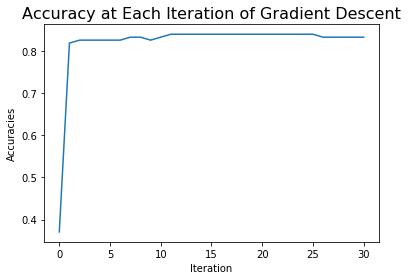

In [17]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Raw Python Version
Based on https://github.com/jstremme/l2-regularized-logistic-regression but without regularization and vectorization of matrix operations.  Instead `py_lr_grad_descent` computes the gradient on each sample sequentially, unlike spark which will compute the gradient on each sample but in parallel.

### Training Functions

In [18]:
def py_lr_grad(w, x, y):
    
    return x * (1 / (1 + np.exp(-y * np.dot(w, x))) - 1) * y

In [19]:
def py_lr_grad_descent(w, X, y, n, learning_rate, n_iter, v):
    
    ws = [w.copy()]
    for i in range(0, n_iter):
    
        gradient_total = 0
        for j in range(0, n, 1): # replaced with map and reduce in spark
            x_j = X[j]
            y_j = y[j]
            gradient_total += py_lr_grad(w, x_j, y_j)

        w -= learning_rate * gradient_total * 1/n # set equal to minus instead of subtracting?
        ws.append(w.copy())
        
        if v:
            print('Objective function at iteration {}: {}'.format(i, nplr.obj(X, y, beta=w, lambda_penalty=0)))
    
    return ws

### Initialized_parameters

In [20]:
w = np.zeros(Xt.shape[1])
# w = np.random.uniform(-1, 1, (Xt.shape[1]))
n = Xt.shape[0]
learning_rate = 0.1
n_iter = 30
v = 1

### Run Gradient Descent

In [21]:
ws = py_lr_grad_descent(w, Xt, yt, n, learning_rate, n_iter, v)

Objective function at iteration 0: 0.6915232371657642
Objective function at iteration 1: 0.6899110502884073
Objective function at iteration 2: 0.6883104355690653
Objective function at iteration 3: 0.6867212213010597
Objective function at iteration 4: 0.6851432469814183
Objective function at iteration 5: 0.683576362032173
Objective function at iteration 6: 0.6820204246717692
Objective function at iteration 7: 0.6804753009192028
Objective function at iteration 8: 0.6789408637154855
Objective function at iteration 9: 0.6774169921487991
Objective function at iteration 10: 0.675903570771266
Objective function at iteration 11: 0.6744004889966435
Objective function at iteration 12: 0.6729076405694925
Objective function at iteration 13: 0.6714249230974484
Objective function at iteration 14: 0.669952237639199
Objective function at iteration 15: 0.668489488341629
Objective function at iteration 16: 0.6670365821203479
Objective function at iteration 17: 0.6655934283784872
Objective function at it

### Predict

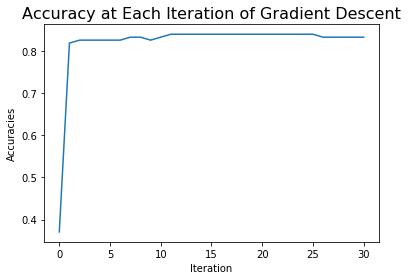

In [22]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Parallelized Numpy Version.
Implementation from https://github.com/jstremme/l2-regularized-logistic-regression.  

### Run Gradient Descent

In [23]:
ws = nplr.l2_log_reg(Xt, yt, lambda_penalty=0, eps=0.001, v=0)

### Predict

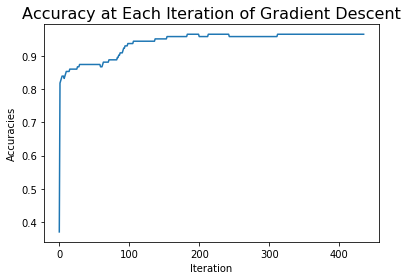

In [24]:
preds = nplr.predict_all(ws, Xt_test)
nplr.plot_accuracies(preds, yt_test)

### Spark MlLib Version

In [ ]:
train_df = nplr.to_df_with_class(X_train_scaled, y_train)
test_df = nplr.to_df_with_class(X_test_scaled, y_test)
target_column = 'class'

In [ ]:
to_assemble = [item for item in train_df.columns if item != target_column]
assembler = VectorAssembler(inputCols=to_assemble, outputCol='features')
train_vector = assembler.transform(train_df)
test_vector = assembler.transform(test_df)

In [ ]:
lr = LogisticRegression(labelCol=target_column, featuresCol='features',
                        elasticNetParam=1, tol=0.001, standardization=False, fitIntercept=True)

In [ ]:
%%time
lr.fit(train_vector)

In [ ]:
y_prob = lr.predict(test_vector)